<a href="https://colab.research.google.com/github/AsraniSanjana/All_Codes/blob/main/All_Semester_Codes/ML_sem7/models/miniproject/ML_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


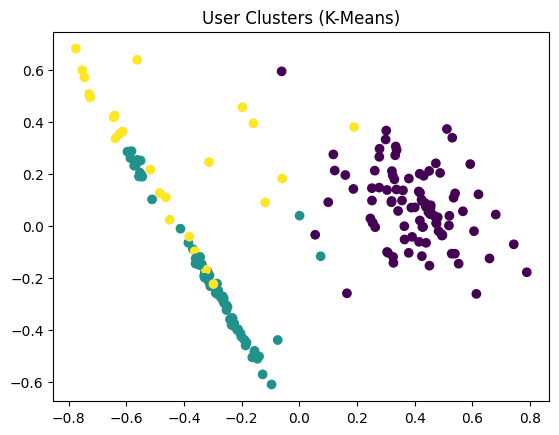

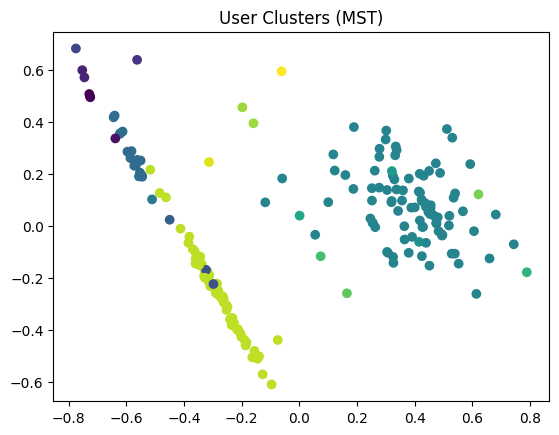

KeyError: ignored

In [ ]:
!pip install tabulate

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
import ast

movies_file_path = '/content/drive/MyDrive/Life of Sem 7/ML/Project Datasets/movies.csv'
ratings_file_path = '/content/drive/MyDrive/Life of Sem 7/ML/Project Datasets/ratings.csv'

# Load the datasets
movies = pd.read_csv(movies_file_path)
ratings = pd.read_csv(ratings_file_path)

import pandas as pd
import ast
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
movies_data = pd.read_csv(movies_file_path)
ratings_data = pd.read_csv(ratings_file_path)

# Step 1: Calculate user's genre preferences
def calculate_genre_preferences(user_id, ratings, movies):
    user_ratings = ratings[ratings['userId'] == user_id]
    genre_preferences = {}

    for index, row in user_ratings.iterrows():
        movie_id = row['movieId']
        movie_info = movies[movies['movieId'] == movie_id]

        if not movie_info.empty:
          movie_genres = ast.literal_eval(movie_info['genres'].values[0])
          rating = row['rating']
          for genre in movie_genres:
                genre_id = genre['id']
                if genre_id not in genre_preferences:
                    genre_preferences[genre_id] = {'sum_ratings': 0, 'count_ratings': 0}

                genre_preferences[genre_id]['sum_ratings'] += rating
                genre_preferences[genre_id]['count_ratings'] += 1

    # Normalize genre preferences
    for genre_id, prefs in genre_preferences.items():
        prefs['normalized_rating'] = prefs['sum_ratings'] / prefs['count_ratings']

    return genre_preferences

# Step 2: Calculate genre preferences for all users
unique_users = ratings_data['userId'].unique()
user_genre_preferences = {}

for user_id in unique_users:
    genre_prefs = calculate_genre_preferences(user_id, ratings_data, movies_data)
    user_genre_preferences[user_id] = genre_prefs

# Step 3: Prepare the data for K-Means clustering
genre_preferences_matrix = []
for user_id, genre_prefs in user_genre_preferences.items():
    row = [genre_prefs.get(genre_id, {'normalized_rating': 0})['normalized_rating'] for genre_id in range(1, 21)]
    genre_preferences_matrix.append(row)

# Step 4: Apply K-Means clustering
num_clusters_kmeans = 3
scaler = StandardScaler()
genre_preferences_scaled = scaler.fit_transform(genre_preferences_matrix)
kmeans = KMeans(n_clusters=num_clusters_kmeans, random_state=42)
user_clusters_kmeans = kmeans.fit_predict(genre_preferences_scaled)

# Add K-Means cluster information to the user_genre_preferences dictionary
for i, user_id in enumerate(unique_users):
    user_genre_preferences[user_id]['kmeans_cluster'] = user_clusters_kmeans[i]

# Step 5: Prepare the data for Minimum Spanning Tree (MST) clustering
scaler = MinMaxScaler()
genre_preferences_scaled = scaler.fit_transform(genre_preferences_matrix)
distance_matrix = distance.pdist(genre_preferences_scaled)
linkage_matrix = hierarchy.linkage(distance_matrix, method='single')

# Step 6: Apply MST clustering
# Use fcluster to obtain clusters from the linkage matrix based on a threshold
threshold_mst = 0.2  # You can adjust the threshold as needed
user_clusters_mst = hierarchy.fcluster(linkage_matrix, t=threshold_mst, criterion='distance')

# Add MST cluster information to the user_genre_preferences dictionary
for i, user_id in enumerate(unique_users):
    user_genre_preferences[user_id]['mst_cluster'] = user_clusters_mst[i]

# Step 7: Visualize the clusters (2D plot) using PCA for K-Means
pca = PCA(n_components=2)
reduced_genre_preferences_kmeans = pca.fit_transform(genre_preferences_scaled)

plt.scatter(reduced_genre_preferences_kmeans[:, 0], reduced_genre_preferences_kmeans[:, 1], c=user_clusters_kmeans)
plt.title("User Clusters (K-Means)")
plt.show()

# Step 8: Visualize the clusters (2D plot) using PCA for MST
reduced_genre_preferences_mst = pca.fit_transform(genre_preferences_scaled)

plt.scatter(reduced_genre_preferences_mst[:, 0], reduced_genre_preferences_mst[:, 1], c=user_clusters_mst)
plt.title("User Clusters (MST)")
plt.show()

# Define a function to generate movie recommendations
def generate_movie_recommendations(cluster_id, genre_prefs, cluster_type, movies, ratings):
    # Calculate the cluster's preferred genre ID based on genre preferences
    cluster_preferred_genre_id = max(genre_prefs, key=lambda k: genre_prefs[k]['normalized_rating'])

    # Find movies in the recommended genre that the cluster hasn't seen
    cluster_ratings = ratings[ratings['userId'].isin([user_id for user_id, prefs in user_genre_preferences.items() if prefs[f'{cluster_type}_cluster'] == cluster_id])]
    cluster_rated_movies = cluster_ratings['movieId'].tolist()

    all_movies = movies['movieId'].tolist()
    cluster_not_seen_movies = list(set(all_movies) - set(cluster_rated_movies))

    recommended_movies = []

    for movie_id in cluster_not_seen_movies:
        movie_info = movies[movies['movieId'] == movie_id]

        if not movie_info.empty:
            movie_genres = ast.literal_eval(movie_info['genres'].values[0])

            # Convert movie_genres to a list of strings
            genres = [genre['name'] for genre in movie_genres]
            genres_str = ', '.join(genres)  # Convert genres to a string

            for genre in movie_genres:
                genre_id = genre['id']
                if genre_id == cluster_preferred_genre_id and genre_id in genre_prefs:
                    rating = genre_prefs[genre_id]['normalized_rating']
                    recommended_movies.append((movie_id, rating, genres_str))

    # Sort recommended movies by rating in descending order
    recommended_movies.sort(key=lambda x: x[1], reverse=True)

    # Get the top 2 recommended movies or fewer if there are less than 2
    top_recommended_movies = recommended_movies[:2]

    return top_recommended_movies

# Step 9: Generate movie recommendations for K-Means clusters
recommendation_data_kmeans = []

for cluster_id in range(num_clusters_kmeans):
    top_recommended_movies = generate_movie_recommendations(cluster_id, user_genre_preferences[cluster_id], 'kmeans', movies_data, ratings_data)

    recommendations = [f"Cluster (K-Means) {cluster_id}"]

    for i, (movie_id, rating, genres_str) in enumerate(top_recommended_movies):
        movie_info = movies_data[movies_data['movieId'] == movie_id]
        title = movie_info['title'].values[0]
        recommendations.append(f"Movie {i + 1}: {title}\nGenres: {genres_str}\nRating: {rating}")

    recommendation_data_kmeans.append(recommendations)

# Step 10: Generate movie recommendations for MST clusters
recommendation_data_mst = []

for cluster_id in range(max(user_clusters_mst)):
    top_recommended_movies = generate_movie_recommendations(cluster_id, user_genre_preferences[cluster_id], 'mst', movies_data, ratings_data)

    recommendations = [f"Cluster (MST) {cluster_id}"]

    for i, (movie_id, rating, genres_str) in enumerate(top_recommended_movies):
        movie_info = movies_data[movies_data['movieId'] == movie_id]
        title = movie_info['title'].values[0]
        recommendations.append(f"Movie {i + 1}: {title}\nGenres: {genres_str}\nRating: {rating}")

    recommendation_data_mst.append(recommendations)

# Step 11: Create tables for recommendation data
table_headers = ["Cluster Name", "Movie Recommended 1", "Movie Recommended 2"]
table_data_kmeans = []
table_data_mst = []

for row_kmeans, row_mst in zip(recommendation_data_kmeans, recommendation_data_mst):
    table_data_kmeans.append([row_kmeans[0], row_kmeans[1], row_kmeans[2]])
    table_data_mst.append([row_mst[0], row_mst[1], row_mst[2]])

# Print the tables using tabulate
table_kmeans = tabulate(table_data_kmeans, headers=table_headers, tablefmt="fancy_grid")
table_mst = tabulate(table_data_mst, headers=table_headers, tablefmt="fancy_grid")

print("Movie Recommendations for K-Means Clusters:")
print(table_kmeans)
print("\nMovie Recommendations for MST Clusters:")
print(table_mst)

# Step 12: Generate network graphs for both K-Means and MST
import networkx as nx
import matplotlib.pyplot as plt

def calculate_similarity(cluster1, cluster2, cluster_type):
    # Convert cluster dictionaries into arrays for similarity calculation
    cluster1_array = [cluster1.get(genre_id, {'normalized_rating': 0})['normalized_rating'] for genre_id in range(1, 21)]
    cluster2_array = [cluster2.get(genre_id, {'normalized_rating': 0})['normalized_rating'] for genre_id in range(1, 21)]

    # Calculate cosine similarity between the two clusters
    similarity = cosine_similarity([cluster1_array], [cluster2_array])
    return similarity[0][0]

# Create a graph for K-Means
G_kmeans = nx.Graph()

# Add nodes for K-Means clusters
for cluster_id in range(num_clusters_kmeans):
    G_kmeans.add_node(f'Cluster (K-Means) {cluster_id}')

# Add edges between K-Means clusters based on similarity
for i, cluster_id1 in enumerate(range(num_clusters_kmeans)):
    for j, cluster_id2 in enumerate(range(num_clusters_kmeans)):
        if i < j:
            similarity = calculate_similarity(user_genre_preferences[i], user_genre_preferences[j], 'kmeans')
            G_kmeans.add_edge(f'Cluster (K-Means) {i}', f'Cluster (K-Means) {j}', weight=similarity)

# Create a graph for MST
G_mst = nx.Graph()

# Add nodes for MST clusters
for cluster_id in range(max(user_clusters_mst)):
    G_mst.add_node(f'Cluster (MST) {cluster_id}')

# Add edges between MST clusters based on similarity
for i, cluster_id1 in enumerate(range(max(user_clusters_mst))):
    for j, cluster_id2 in enumerate(range(max(user_clusters_mst))):
        if i < j:
            similarity = calculate_similarity(user_genre_preferences[i], user_genre_preferences[j], 'mst')
            G_mst.add_edge(f'Cluster (MST) {i}', f'Cluster (MST) {j}', weight=similarity)


# Draw the network graph for K-Means
pos_kmeans = nx.spring_layout(G_kmeans)
labels_kmeans = nx.get_edge_attributes(G_kmeans, 'weight')

# Draw the network graph for MST
pos_mst = nx.spring_layout(G_mst)
labels_mst = nx.get_edge_attributes(G_mst, 'weight')

# Plot network graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_kmeans, pos_kmeans, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G_kmeans, pos_kmeans, edge_labels=labels_kmeans, font_color='red', font_size=8, font_weight='bold')
plt.title("Cluster Similarity Network Graph (K-Means)")

plt.subplot(1, 2, 2)
nx.draw(G_mst, pos_mst, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G_mst, pos_mst, edge_labels=labels_mst, font_color='red', font_size=8, font_weight='bold')
plt.title("Cluster Similarity Network Graph (MST)")

plt.tight_layout()
plt.show()